In [1]:
import matplotlib.pyplot as plt
import numpy as np

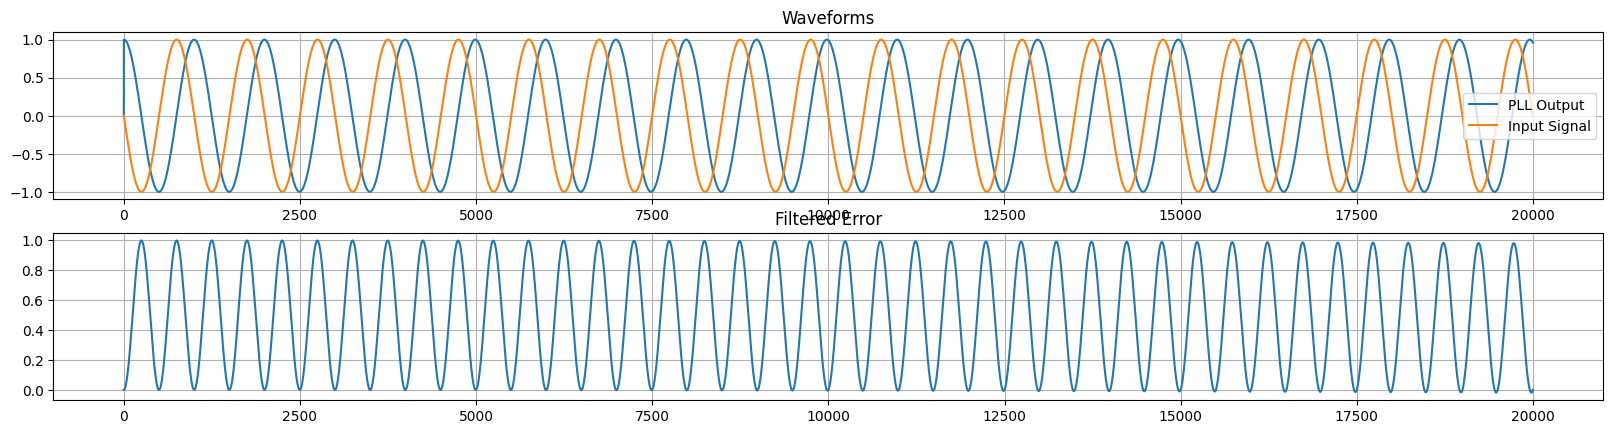

In [26]:
# This shit works. Need to make sample rate configurable in the PLL



class PhaseDetector:
    def __init__(self) -> None:
        pass

    def proc( self, sigIn, sigOut ):
        return sigIn * sigOut


class LoopFilter:
    def __init__( self, K_i, K_p ) -> None:
        self.K_i = K_i
        self.K_p = K_p
        self.integrator = 0
    
    def proc( self, e_D ):
        self.integrator += self.K_i * e_D / fs

        return self.K_p * e_D + self.integrator

class NumericallyControlledOscillator:
    def __init__( self, K_0 ) -> None:
        self.prevPhaseEstimate = 0
        self.K_0 = K_0

    def proc( self, e_F ):
        prev = self.prevPhaseEstimate
        new = prev + self.K_0 * e_F
        
        if new > 2*np.pi:
            new -= 2*np.pi
        self.prevPhaseEstimate = new
        
        return prev
    

class PhaseLockedLoop:
    def __init__( self, K_i, K_p, K_0, pll_f, fs ) -> None:
        self.pd = PhaseDetector()
        self.lf = LoopFilter( K_i, K_p )
        self.nco = NumericallyControlledOscillator( K_0 )

        self.last_sin_out = 0
        self.last_phase_estimate = 0
        self.pll_f = pll_f

        self.theta = 0
        self.fs = fs


    """
    The original code for this seemed pretty interested in delaying the output by one sample (or something along those lines)
    I took that all out and it appears to still work fine
    """
    def proc( self, in_, ):
        _e_D = self.pd.proc( in_, self.last_sin_out )

        #loop filter
        _e_F = self.lf.proc( _e_D )

        _phase_estimate = self.nco.proc( _e_F )        

        # The phase of our LO, which is additionally modified by the phase coming from our NCO.
        # IDK man, the NCO is a bit of a misnomer because its outputting a phase, not a signal
        self.theta += 2*np.pi*self.pll_f/self.fs
        if self.theta > 2*np.pi:
            self.theta -= 2*np.pi

        # These were originally n+1
        _sin_out = -np.sin( self.theta + _phase_estimate )
        _cos_out = np.cos( self.theta + _phase_estimate )

        self.last_sin_out = _sin_out

        return _cos_out, _sin_out, _e_D
k = 1
N = 15
K_p = 0.2667
K_i = 0.0178
K_0 = 1

fs = 10000
duration_secs = 2
t = np.linspace(0,duration_secs, int(duration_secs*fs))

in_A      = 1
in_f_Hz   = 10
in_phi    = np.random.normal(0, 0.0, size=len(t)) + np.pi
in_sig    = in_A * np.sin( 2*np.pi * in_f_Hz * t + in_phi )
in_sig    += np.random.normal(0, 0.0, size=len(t)) # AWGN

e_D = [] #phase-error output
cos_out = [0]



pll = PhaseLockedLoop( K_i, K_p, K_0, 10, fs )
for n in range(len(t)):
    _cos_out, _sin_out, _e_D = pll.proc( in_sig[n] )

    cos_out.append( _cos_out )
    e_D.append( _e_D )



# Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

# Set up Axes
ax1 = fig.add_subplot(411)
ax1.plot(cos_out, label='PLL Output')
plt.grid()
ax1.plot(in_sig, label='Input Signal')
plt.legend()
ax1.set_title('Waveforms')

# Show the plot
#plt.show()

ax2 = fig.add_subplot(412)
ax2.plot( e_D )
plt.grid()
ax2.set_title('Filtered Error')
plt.show()

Text(0.5, 1.0, 'Waveforms')

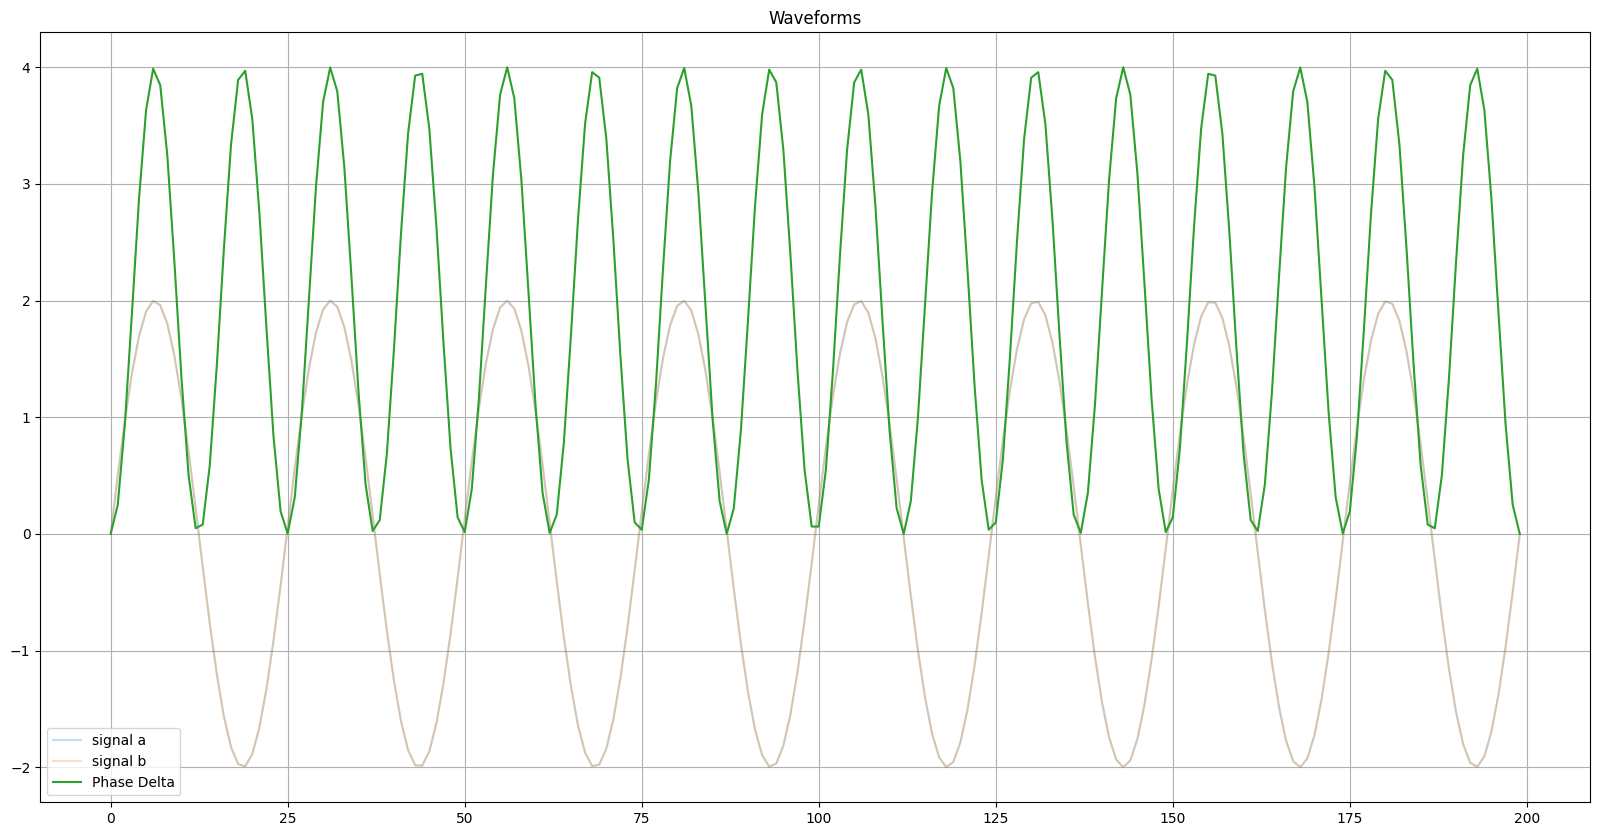

In [3]:
# OK, what does the phase detector do?

fs = 100
duration_secs = 2
t = np.linspace(0,duration_secs, int(duration_secs*fs))

a = 2.0 * np.sin( 2*np.pi * 4*t )
b = 2.0 * np.sin( 2*np.pi * 4*t )

pd = PhaseDetector()

phase = []
for i in range(len(a)):
    phase.append( pd.proc( a[i], b[i] ) )

    # Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

ax1 = fig.add_subplot(111)
ax1.plot(a, label='signal a', alpha=0.25 )
ax1.plot(b, label='signal b', alpha=0.25 )
ax1.plot(phase, label='Phase Delta')
plt.grid()
plt.legend()
ax1.set_title('Waveforms')

Text(0.5, 1.0, 'Waveforms')

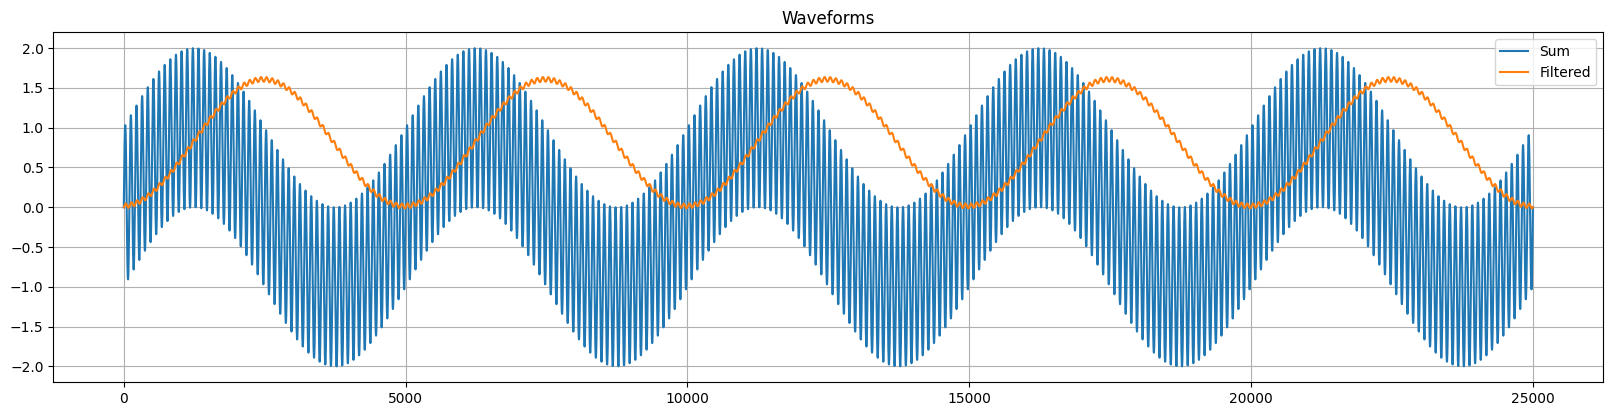

In [24]:
# OK what does the loop filter do?
# OK, what does the phase detector do?

class LoopFilter:
    def __init__( self, K_i, K_p ) -> None:
        self.K_i = K_i
        self.K_p = K_p
        self.integrator = 0
    
    def proc( self, e_D ):
        self.integrator += (self.K_i * e_D) / (1.0*fs)
#         return self.integrator
        return self.K_p * e_D + self.integrator

K_p = 0.025
K_i = 5
# K_i = 1.0

fs = 5000
duration_secs = 5
t = np.linspace(0,duration_secs, int(duration_secs*fs))

a = 1.0 * np.sin( 2*np.pi * 1*t )
b = 1.00 * np.sin( 2*np.pi * 50*t )
s = a+b

pd = PhaseDetector()
lf = LoopFilter( K_i, K_p )

phase = []
filtered = []
for i in range(len(a)):
    filtered.append ( lf.proc( s[i] ) )
    # Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

ax2 = fig.add_subplot(211)
ax2.plot(s, label='Sum')
ax2.plot(filtered, label='Filtered')
plt.grid()
plt.legend()
ax2.set_title('Waveforms')